# RoIPooling in TensorFlow

TensorFlow does not to my knowledge enable max pooling with dynamic kernel size. Here I have written a function that does region of interest pooling (RoIPooling), which is used in object detection architectures such as Fast RCNN. This was more of an exercise in writing this function without using a tf.while_loop rather than necessarily an implementation that would be useful in practice. 

It is still a work in progress and I have not actually used it in a detection model yet! It works as follows:

- A grid the size of the feature maps is generated
- The RoIs are used to obtain bounding x and y coordinates of the n x n blocks into which the grid is divided for pooling
- For each point in the grid we determine if the coordinates of the point fall within the bounding coordinates 
- We do this separately for x and y and then do a pairwise comparison (using broadcasting) to determine for each RoI if each grid coordinate is in one of the blocks of that RoI
- Then we use the result to mask out for each block all the regions of the image outside the block 
- Points outside the RoI will be False for all the blocks so they will be masked out
- Finally we call a pooling function such as max across the image dimensions are left with a tensor of shape pool_size x pool_size x n_channels for each RoI in each image as required.
- Broadcasting is used extensively
- Unlike max pooling with a kernel the blocks over which pooling happens might be of different sizes.
- For RoIs that evenly divide poolsize the result should the same as applying max pooling with a kernel and stride of [h/pool_size, w/pool_size] over the RoI.

In [1503]:
import numpy as np
import tensorflow as tf

In [1504]:
def roi_pooling(x, bboxes, poolsize, pool_type='max',normed=True):
    # x: batch_size(N) x H x W x C
    # bboxes: batch_size(N) x n_rois(R) x 4, should be in the range [0,1]
    # Will work for single image and roi i.e. x: H x W x C, bboxes: R x 4 by adding single dimensions
    
    # If bboxes are zero-padded where fewer than R RoIs in an image, then function simply returns zeros
    
    assert pool_type in ['max', 'avg']
    
    if pool_type=='max':
        pool_fn = tf.reduce_max
    else:
        pool_fn = tf.reduce_mean
    
    shape = tf.shape(x)[1:3]
    
    # H x W
    grid = tf.stack(tf.meshgrid(tf.range(shape[0]), tf.range(shape[1]), indexing='ij'), axis=-1)
    grid = tf.to_float(grid)/tf.to_float(shape)
    
    #For debugging 
    if not normed:
        grid = grid*tf.to_float(shape)
        
    #N x R 1 x 4
    bboxes = bboxes[:, :, None]
    
    # N x R x 1 x 2
    step = (bboxes[...,2:] - bboxes[...,:2])/pool_size

    # N x R x (pool_size(P) + 1) x 2
    ranges = bboxes[..., :2] + tf.range(pool_size+1, dtype=tf.float32)[None, None,:, None]*step
    ranges = tf.to_float(ranges)
    # grid[None,None,..., None,:] -> 1 x 1 x H x W x 1 x 2
    # ranges[:,:,None,None,:-1]   -> N x R x 1 x 1 x P x 2
    # N x R x H x W x P x 2
    in_range_xy = tf.logical_and(grid[None,None,..., None,:] >= ranges[:,:,None,None,:-1], 
                                 grid[None,None,...,None,:] < ranges[:,:,None,None,1:])
    
    # in_range_xy[...,None,0]  ->    N x R x H x W x P x 1
    # in_range_xy[...,None,:,1]  ->  N x R x H x W x 1 x P
    # N x R x H x W x P x P
    pool_mask = tf.logical_and(in_range_xy[...,None,0], in_range_xy[...,None,:,1])
    
    # N x R x H x W x P x P x 1
    pool_mask = tf.to_float(pool_mask[...,None])
    
    # x[:,None,...,None,None,:]   ->   N x 1 x H x W x 1 x 1 x C
    # N x R x P x P x C
    pool = pool_fn(x[:,None,...,None,None,:]*pool_mask, axis=(2, 3))
    
    return pool_mask, pool

In [1505]:
def crop_im(im, bbox):
    x1, y1, x2, y2 = bbox
    return im[x1:x2, y1:y2]

In [1506]:
h = 50
w = 70
n = 4
shape = np.array([h,w])
bb1 = [10,10,18,18]
bb2 = [21,24,34,35]
bb3 = [1,2, 9, 9]
bb4 = [1,2, 8, 8]
bb5 = [9, 12, 17, 19]
bb6 = [0, 0, 0, 0]
bb = np.array([[bb1, bb2, bb3],
               [ bb4, bb5, bb6]])/np.tile(shape[None,None], [1,1,2])




In [1507]:
im = np.random.random(size=(2,h,w,1))

In [1508]:
img = tf.placeholder(shape=[None,None,None,None], dtype=tf.float32)
bbox = tf.placeholder(shape=[None,None,4], dtype=tf.float32)
pool_size = tf.placeholder(shape=[], dtype=tf.float32)

pool_mask, pool = roi_pooling(img, bbox, pool_size)

In [1509]:
with tf.Session() as sess:
    pmask, p = sess.run([pool_mask, pool], {img:im, bbox:bb, pool_size:n})

In [1510]:
p.shape

(2, 3, 4, 4, 1)

In [1511]:
crop = crop_im(im[1,...,0], bb4)

In [1512]:
crop.round(2)

array([[0.91, 0.33, 0.77, 0.72, 0.74, 0.78],
       [0.64, 0.68, 0.39, 0.64, 0.29, 0.53],
       [0.03, 0.83, 0.68, 0.23, 0.35, 0.45],
       [0.61, 0.14, 0.19, 0.01, 0.55, 0.8 ],
       [0.89, 0.66, 0.49, 0.79, 0.62, 0.02],
       [0.48, 0.39, 0.83, 0.38, 0.23, 0.54],
       [0.39, 0.22, 0.57, 0.8 , 0.18, 0.43]])

In [1513]:
p[1,0,...,0].round(2)

array([[0.91, 0.77, 0.74, 0.78],
       [0.83, 0.68, 0.55, 0.8 ],
       [0.89, 0.83, 0.79, 0.54],
       [0.39, 0.57, 0.8 , 0.43]], dtype=float32)

In [1514]:
p.shape

(2, 3, 4, 4, 1)

In [1515]:
mask2 = pmask[1,...,0]
mask2_dense = np.argmax(np.reshape(mask2, (3,h,w,n**2)), axis=-1)
mask2_all = np.sum(mask2_dense, axis=0)

Note that bb6 does not give rise to a non-zero mask

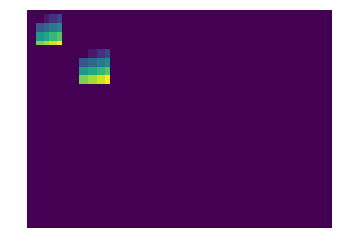

In [1516]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mask2_all)
plt.axis('off');

In [1543]:
def plot_grid(values, points, color_values=None, offx=0, offy=0, th=0, maxgrid=None, maxonly=False):
    color_values = color_values if color_values is not None else values

    for i, (color_value, value, point) in enumerate(zip(color_values, values, points)):
        if maxgrid is not None and np.isclose(value, maxgrid[i]):
            cl = 'red'
            plt.text(point[0]+offx, point[1]+offy,np.round(value,1), 
                 color=cl)
        elif not maxonly:
            cl = 'white' if color_value < th else 'k'
            plt.text(point[0]+offx, point[1]+offy,np.round(value,1), 
                 color=cl)

In [1544]:
def points_from_bbox(bbox):
    x1, y1, x2, y2 = bbox 
    grid = np.meshgrid(np.arange(y2-y1), np.arange(x2-x1), indexing='xy')
    return np.reshape(np.stack(grid,-1), [-1,2])

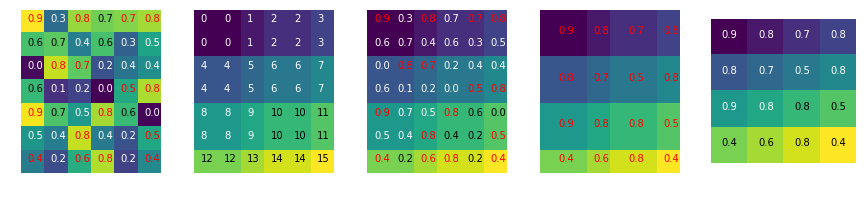

In [1546]:
crop_mask = crop_im(pmask[1,0,...,0].reshape(h,w,-1).argmax(-1), bb4)
maxes = p[1,0,...,0].reshape(-1)[crop_mask]
points = points_from_bbox(bb4)
n_blocks = len(np.unique(crop_mask))
mids = np.array([points[crop_mask.ravel()==i].mean(axis=0) for i in range(n_blocks) ])
mids = mids[crop_mask].reshape([-1,2])


plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.imshow(crop)
plt.axis('off')
plot_grid(crop.reshape(-1), points, offx=-0.2, offy=0, th=0.6, maxgrid=maxes.ravel())

plt.subplot(1,5,2)
plt.imshow(crop_mask)
plt.axis('off')
plot_grid(crop_mask.reshape(-1), points, offx=-0.2, offy=0, th=10)

plt.subplot(1,5,3)
plt.imshow(crop_mask)
plt.axis('off')
plot_grid(crop.reshape(-1), points, crop_mask.reshape(-1), offx=-0.2, offy=0, th=10, 
          maxgrid=maxes.ravel())


plt.subplot(1,5,4)
crop_mask = crop_im(pmask[1,0,...,0].reshape(h,w,-1).argmax(-1), bb4)
plt.imshow(crop_mask)
plt.axis('off')
plot_grid(crop.reshape(-1), mids, offx=-0.2, offy=0, th=0.6, maxgrid=maxes.ravel(), maxonly=True)


plt.subplot(1,5,5)
plt.imshow(np.arange(16).reshape((4,4)))
pool_points = points_from_bbox([0,0,n,n])
plt.axis('off')
plot_grid(p[1,0,...,0].ravel(), pool_points, np.arange(16), offx=-0.2, offy=0, th=10)


In [1547]:
def equiv_kernel(bbox, n):
    x1, y1, x2, y2 = bbox
    return (x2-x1)//n, (y2-y1)//n

In [1548]:
bb_even1 = [3, 2, 15, 10]
bb_even2 = [25, 20, 37, 28]
bb_even = np.array([bb_even1, bb_even2])#/np.tile(shape, 2)[None]

#Sometimes roipool does not divide grid in even number of blocks even if divisible,
#but using non-normalized co-ordinates seems to make this work fine - in practice
#unlikely to be divisible in equal sized blocks and hopefully differences between
#detections in terms of splitting will even out 

pool_mask_even, pool_even = roi_pooling(img, bbox, pool_size, normed=False)

ker = equiv_kernel(bb_even1, n)
maxpool = tf.layers.max_pooling2d(img, pool_size=ker, strides=ker, padding='valid')
with tf.Session() as sess:
    pmask_even, p_even = sess.run([pool_mask_even, pool_even], {img: im[:1], bbox:bb_even[None], pool_size:n })
    mpool1 = sess.run(maxpool, {img: crop_im(im[0,...,0], bb_even1)[None,...,None] })
    mpool2 = sess.run(maxpool, {img: crop_im(im[0,...,0], bb_even2)[None,...,None] })

In [1549]:
mpool = np.concatenate([mpool1, mpool2], axis=0)

In [1550]:
#Sometimes is not true as does not (due to floating point error maybe ???) as roipool does
#divide grid in even number of blocks even if divisible
np.allclose(mpool, p_even[0])

True

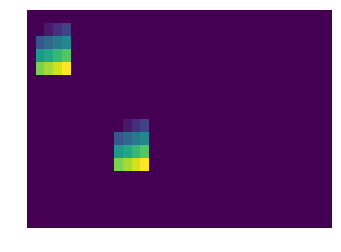

In [1551]:
mask2 = pmask_even[0,...,0]
mask2_dense = np.argmax(np.reshape(mask2, (2,h,w,n**2)), axis=-1)
mask2_all = np.sum(mask2_dense, axis=0)
plt.imshow(mask2_all)
plt.axis('off');

In [1552]:
crop_im(pmask_even[0,1,...,0].reshape(h,w,-1).argmax(-1), bb_even2)

array([[ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [12, 12, 13, 13, 14, 14, 15, 15],
       [12, 12, 13, 13, 14, 14, 15, 15],
       [12, 12, 13, 13, 14, 14, 15, 15]])

In [1553]:
crop_im(pmask_even[0,0,...,0].reshape(h,w,-1).argmax(-1), bb_even1)

array([[ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 0,  0,  1,  1,  2,  2,  3,  3],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 4,  4,  5,  5,  6,  6,  7,  7],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [ 8,  8,  9,  9, 10, 10, 11, 11],
       [12, 12, 13, 13, 14, 14, 15, 15],
       [12, 12, 13, 13, 14, 14, 15, 15],
       [12, 12, 13, 13, 14, 14, 15, 15]])